# Data Mining Project  #
## Predicting Startup Profitability Using a Classification Model ##

This notebook analyzes data related to startup companies.

**Data Source:**
[Kaggle - Startup Database](https://www.kaggle.com/datasets/samayashar/startup-growth-and-funding-trends?resource=download)

**Author:** Laila ALkaabi  
**Date:** July 2025  
**Model Type:** Decision Tree Classifier  
**Evaluation Metrics:** Accuracy, Precision, Recall, F1 Score  

### 1. Import Required Libraries ###

In [1]:
import numpy as np
import pandas as pd

# For encoding categorical features
from sklearn.preprocessing import LabelEncoder

# For splitting data
from sklearn.model_selection import train_test_split

# For building the model
from sklearn.tree import DecisionTreeClassifier

# For model evaluation metrics
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay

# For visualization
import matplotlib.pyplot as plt


### 2. Data Loading ###

In [2]:
# Read the CSV file into a DataFrame
data_file = 'Startup_Database.csv'
df_data  = pd.read_csv(data_file, header=None)

# Set column names:
df_data.columns = [
    'Startup Name', 
    'Industry', 
    'Funding Rounds', 
    'Funding Amount', 
    'Valuation', 
    'Revenue', 
    'Employees', 
    'Market Share', 
    'Profitable', 
    'Founded Year', 
    'Continent', 
    'Exit Status'
]
display(df_data)

# Create Copy of data 
df = df_data.copy()

# Number of Columns and Rows
num_cols = df.shape[1]
num_rows = df.shape[0]
print(f'Number of Columns in Data : {num_cols}')
print(f'Number of Rows in Data : {num_rows}')

,Startup Name,Industry,Funding Rounds,Funding Amount,Valuation,Revenue,Employees,Market Share,Profitable,Founded Year,Continent,Exit Status
0,Startup_1,IoT,1,101.09,844.75,67.87,1468,5.20,0,2006,Europe,Private
1,Startup_2,EdTech,1,247.62,3310.83,75.65,3280,8.10,1,2003,South America,Private
2,Startup_3,EdTech,1,109.24,1059.37,84.21,4933,2.61,1,1995,South America,Private
3,Startup_4,Gaming,5,10.75,101.90,47.08,1059,2.53,0,2003,South America,Private
4,Startup_5,IoT,4,249.28,850.11,50.25,1905,4.09,0,1997,Europe,Acquired
...,...,...,...,...,...,...,...,...,...,...,...,...
495,Startup_496,EdTech,2,181.86,2378.65,59.64,3331,0.58,1,1993,Europe,Private
496,Startup_497,AI,2,107.34,1394.58,10.22,2223,5.85,0,2019,South America,Private
497,Startup_498,E-Commerce,1,160.29,502.09,84.73,2222,4.32,0,2019,Australia,Private
498,Startup_499,Gaming,5,234.65,2814.52,53.16,4972,5.53,0,2011,Europe,Private


Number of Columns in Data : 12
Number of Rows in Data : 500


### 3. Data Cleaning ###

In [3]:
#Separate columns into numeric and string types based on their data types
numeric_cols = []
string_cols = []

for col in df.columns:
    if df[col].dtype in ['int64', 'int32', 'float64', 'float32']:
        numeric_cols.append(col)
    else:
        string_cols.append(col)

# clean duplicate rows and empty (NaN) values
df = df.drop_duplicates()
df = df.dropna()

# clean negative values where logically invalid
for col in numeric_cols:
    df = df[df[col]>=0]

# clean outliers use IQR
for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 *IQR
    df = df[(df[col]>lower_bound) & (df[col]< upper_bound)]

#### Data Cleaning Report ####

In [4]:
# Cleaning Data Report  
print(f'Numper of rows after cleaning : {df.shape[0]}')
print(f'Numper of Removed Rows : {num_rows - df.shape[0]}')
print(f'Percentage of Removed Rows : {(num_rows - df.shape[0]) / num_rows*100 :.2f}%')

Numper of rows after cleaning : 499
Numper of Removed Rows : 1
Percentage of Removed Rows : 0.20%


In [5]:
#If you are interested in the removed row
removed_rows = df_data[~df_data.index.isin(df.index)]
#Print it!
#print(removed_rows)

### 4. Building classification models ###

#### 4.1. Preparing data for  models ####

In [6]:
# Encoding categorical columns
le = LabelEncoder()

categorical_cols = ['Industry','Continent', 'Exit Status']

for col in categorical_cols:
    df[col] = le.fit_transform(df[col])


# Create a new feature: Company Age
current_year = 2025
df['Company Age'] = current_year - df['Founded Year']

display(df)

,Startup Name,Industry,Funding Rounds,Funding Amount,Valuation,Revenue,Employees,Market Share,Profitable,Founded Year,Continent,Exit Status,Company Age
0,Startup_1,7,1,101.09,844.75,67.87,1468,5.20,0,2006,2,2,19
1,Startup_2,3,1,247.62,3310.83,75.65,3280,8.10,1,2003,4,2,22
2,Startup_3,3,1,109.24,1059.37,84.21,4933,2.61,1,1995,4,2,30
3,Startup_4,5,5,10.75,101.90,47.08,1059,2.53,0,2003,4,2,22
4,Startup_5,7,4,249.28,850.11,50.25,1905,4.09,0,1997,2,0,28
...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,Startup_496,3,2,181.86,2378.65,59.64,3331,0.58,1,1993,2,2,32
496,Startup_497,0,2,107.34,1394.58,10.22,2223,5.85,0,2019,4,2,6
497,Startup_498,2,1,160.29,502.09,84.73,2222,4.32,0,2019,1,2,6
498,Startup_499,5,5,234.65,2814.52,53.16,4972,5.53,0,2011,2,2,14


#### 4.2. Building Models 1 #####

This model has **all available features** in data

In [7]:
# Step 1: Set features and target columsns
features = ['Industry','Funding Rounds','Funding Amount', 'Valuation','Revenue','Employees','Market Share','Company Age', 'Continent', 'Exit Status']
target = 'Profitable'

# Step 2: Separate data into train data and test data
x = df[features]
y = df[target]

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.3, random_state=29)

# Step 3: Build and train model
model = DecisionTreeClassifier(random_state=42)
model.fit(x_train, y_train)

# Step 4: Model performance evaluation
y_pred = model.predict(x_test)

**Model 1 Result**

Single-Feature Model Evaluation Results:

Accuracy: 50.67%
Precision: 47.76%
Recall: 45.07%
F1 Score: 46.38%


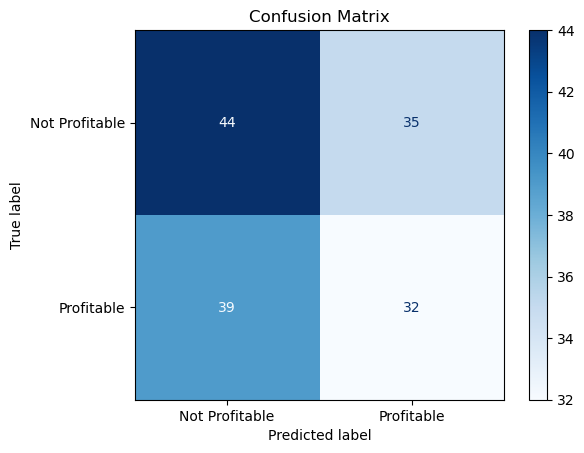

In [8]:
print("Single-Feature Model Evaluation Results:\n")
print(f'Accuracy: {accuracy_score(y_test, y_pred)*100 :.2f}%')
print(f'Precision: {precision_score(y_test, y_pred)*100  :.2f}%')
print(f'Recall: {recall_score(y_test, y_pred)*100  :.2f}%')
print(f'F1 Score: {f1_score(y_test, y_pred)*100  :.2f}%')

cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm, display_labels=['Not Profitable', 'Profitable']).plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

#### 4.3. Building Model 2 ####
This model builded by use some of features in data: **Industry, Funding Amount, Revenue, Employees, Market Share, Company Age** 

In [9]:
# Set Features and Target Columsns
features = ['Industry','Funding Amount','Revenue','Employees','Market Share','Company Age']
target = 'Profitable'


# Separate Data into train data and test data
x = df[features]
y = df[target]

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.3, random_state=29)

# the model
model = DecisionTreeClassifier(random_state=42)

# training
model.fit(x_train, y_train)

# testing -  Predictions
y_pred = model.predict(x_test)

#### Model 2 Result ####

Accuracy: 56.00%
Precision: 53.73%
Recall: 50.70%
F1 Score: 52.17%


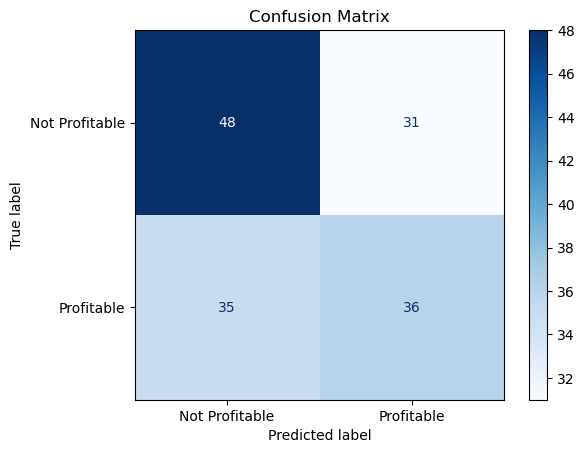

In [10]:
print(f'Accuracy: {accuracy_score(y_test, y_pred)*100  :.2f}%')
print(f'Precision: {precision_score(y_test, y_pred)*100  :.2f}%')
print(f'Recall: {recall_score(y_test, y_pred)*100  :.2f}%')
print(f'F1 Score: {f1_score(y_test, y_pred)*100  :.2f}%')

cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm, display_labels=['Not Profitable', 'Profitable']).plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

### 5. Additional Information ###

In [11]:
# Set Features and Target Columsns
#features = ['Industry','Funding Amount','Revenue','Employees','Market Share','Company Age']
features = ['Industry','Funding Rounds','Funding Amount', 'Valuation','Revenue','Employees','Market Share','Company Age', 'Continent', 'Exit Status']
target = 'Profitable'

results = []

for col in features:

    # Separate Data into train data and test data
    x = df[[col]]
    y = df[target]

    x_train, x_test, y_train, y_test = train_test_split(
        x, y, test_size=0.3, random_state=29)

    # the model
    model = DecisionTreeClassifier(random_state=42)

    # training
    model.fit(x_train, y_train)

    # testing -  Predictions
    y_pred = model.predict(x_test)

    
    acc = accuracy_score(y_test, y_pred)*100
    prec = precision_score(y_test, y_pred, zero_division=0)*100
    rec = recall_score(y_test, y_pred, zero_division=0)*100
    f1 = f1_score(y_test, y_pred, zero_division=0)*100

    results.append({
        'Feature': col,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1 Score': f1
    })
    
results_df = pd.DataFrame(results)
display(results_df)

,Feature,Accuracy,Precision,Recall,F1 Score
0,Industry,55.333333,60.000000,16.901408,26.373626
1,Funding Rounds,50.666667,45.161290,19.718310,27.450980
2,Funding Amount,44.000000,38.983051,32.394366,35.384615
3,Valuation,51.333333,48.214286,38.028169,42.519685
4,Revenue,54.666667,52.173913,50.704225,51.428571
5,Employees,44.000000,40.579710,39.436620,40.000000
6,Market Share,54.666667,52.941176,38.028169,44.262295
7,Company Age,50.666667,45.454545,21.126761,28.846154
8,Continent,52.666667,0.000000,0.000000,0.000000
9,Exit Status,52.666667,0.000000,0.000000,0.000000
